In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
size(filter(x->occursin(string("A"), x), readdir(folder)))[1]

24000

In [3]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return reshape(readdlm(filePath)[4:67, 2], (8,8))
end

getEdepGateBarA0 (generic function with 1 method)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return reshape(readdlm(filePath90)[4:67,2], (8,8))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return readdlm(filePath)[4:515,2]
end

getEdepGateGrid (generic function with 1 method)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [6]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return reshape(readdlm(filePath)[4:67,2], (8,8))
end

getEdepOhioBarA0 (generic function with 1 method)

In [7]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return reshape(readdlm(filePath)[4:67,2], (8,8))
end

getEdepOhioBarA90 (generic function with 1 method)

In [8]:
#getEdepOhioBarA90(1)

In [9]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return inputArray
end

normalize (generic function with 1 method)

In [10]:
#normalize(getEdepOhioBarA90(1))

In [11]:
#normalize(getEdepOhioBarA0(1))

In [12]:
function makeTrainingData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8, 8, 2, trainingSize*numRuns)
    
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i,  (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i,  (r-1)*15)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [13]:
function makeValidationData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8, 8, 2, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i, (r-1)*15 + numRuns*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i, (r-1)*15 + numRuns*15)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [14]:
getEdepGateBarA0(1, (1-1)*15 + 15*15)

8×8 Matrix{Any}:
 15.4884   32.5172   40.743   1163.92  1145.86   46.834   22.3081  17.2566
 14.145    33.9486   43.7668  1114.67  1124.74   48.8679  19.0451  16.6633
  8.30427  24.0437   52.8285  1140.83  1260.51   67.7493  20.5648  12.6735
 17.951    30.5103   56.5757  1204.7   1140.1    53.5811  24.0435  14.435
 12.8398   25.341    52.8848  1281.83  1172.6    54.7688  18.8436  16.0174
 11.0505   26.6646   39.7371  1309.79  1442.98   64.9083  17.6742  12.9493
 17.6571   22.11     42.6313  1203.04  1180.21   46.0074  31.1144  10.478
  8.32462  43.5534  109.729   1149.49  1072.17  101.285   18.6303  56.6006

In [15]:
function makeTargetData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [16]:
#makeTargetData()

In [17]:
function makeValTargetData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15 + 225)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [18]:
#makeValTargetData()

In [19]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Float32}(undef, 8, 8, 2, trainingSize)
    
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [20]:
#makeInputData()

In [21]:
trainingArray = makeTrainingData()

8×8×2×15000 Array{Float32, 4}:
[:, :, 1, 1] =
 14.5191   24.483    47.0369  1265.32  1165.38  60.2629  24.3078  11.4273
 17.8213   22.9725   45.0488  1197.86  1275.79  50.303   27.3961  17.1623
  9.50263  30.5865   43.1852  1265.99  1338.29  83.5827  27.3149  10.6661
  9.98321  20.824    51.0202  1430.8   1468.12  58.4172  25.2697  13.7856
 14.116    17.0707   47.7147  1399.5   1420.59  59.151   28.6669  10.0607
 10.7921   33.15     49.026   1200.67  1329.24  49.1942  30.0544  20.2622
 17.6552   23.2238   64.9896  1233.84  1258.23  62.586   29.8711  13.8479
 14.8835   71.0769  115.176   1253.78  1240.64  81.5056  48.5325  11.627

[:, :, 2, 1] =
 14.8105  26.4538  41.9192  1066.46  1169.23   48.3495  22.839   14.4685
 11.9722  25.6611  48.0718  1178.2   1205.88   44.4876  27.9193  17.1853
 17.2919  25.9948  49.5679  1088.6   1137.21   60.464   29.3549  17.7702
 17.6599  27.8983  58.3398  1157.69  1188.29   62.3831  30.0397  14.4768
 16.9457  19.7162  55.6446  1264.55  1195.86   70.1722 

In [22]:
targetArray = makeTargetData()

512×15000 Matrix{Float32}:
  1.73302  0.55928  1.48867  0.89287  …   0.85891   9.76429   2.15618
  0.33949  1.99577  0.5303   0.93859      0.45228  17.9356    0.0
  1.18177  3.06774  1.46708  1.29063     14.0921    0.0       1.65343
  1.58416  2.31329  0.98799  2.08327     12.9476    0.88577   0.30841
  2.63345  0.68919  2.64448  1.6688       2.00179   0.9801   11.0231
  1.24264  0.26561  1.72411  0.54543  …   5.93487   0.0      27.9867
  0.68612  0.32278  0.01664  0.31405      0.0       0.28935   0.0
 10.4626   0.51756  2.78773  0.5662       0.0       0.38083   1.26254
  0.38071  1.58356  1.49026  1.0653      62.251    24.8851    5.14384
  0.6765   2.01322  0.096    0.19057     44.1376   54.9953    2.98872
  0.87979  2.51411  0.12774  4.01971  …  50.5812   25.877    18.3948
  2.30144  2.17625  0.6975   2.36079     31.0851    0.85116  26.7169
  1.24405  0.96773  0.70585  1.20241      4.82942   1.08167  28.1516
  ⋮                                   ⋱                      
  0.02237  2.8

In [23]:
validationArray = makeValidationData()

8×8×2×3000 Array{Float32, 4}:
[:, :, 1, 1] =
 20.138   32.1663   52.4427  1203.7    971.864  54.4496  25.7266  18.1535
 13.8302  26.352    52.822   1250.3   1126.46   47.7267  26.8282  22.7268
 15.9903  32.0179   61.1513  1237.52  1224.74   59.1928  25.1949  15.495
 15.1472  24.4431   52.8796  1310.8   1220.92   46.1591  19.2926  21.5866
 17.5135  23.7168   42.8937  1430.15  1278.69   48.2975  25.0456  14.7557
 16.029   29.2574   41.7922  1293.78  1304.8    47.2379  26.5717  16.0603
 18.7279  21.1079   50.0174  1217.69  1259.22   59.8358  32.5749  48.6107
 13.8625  18.6153  100.462   1151.8   1244.42   89.9586  75.0965  53.2186

[:, :, 2, 1] =
 16.4262  23.9595   56.5931  1260.13  1066.21   61.9224  27.2325  10.707
 14.2442  22.4955   65.9357  1255.93  1171.24   49.5925  27.3769  12.8723
 20.9062  28.9646   59.3022  1276.64  1239.94   49.0275  22.4255  14.102
 14.7681  36.3802   63.6949  1315.74  1226.84   60.9466  23.4729   9.71859
 19.5595  24.7703   61.452   1312.85  1329.91   42.82

In [24]:
validationTargetArray = makeValTargetData()

512×3000 Matrix{Float32}:
 0.23618   0.2895    3.92071   0.0      …   0.46361   0.0      26.5556
 0.0       1.92183   1.64906   2.32204      0.99593   0.0      18.9116
 2.61043   0.26541   0.82355   0.76612      0.9608    0.51234   0.59569
 0.40921   0.58358   0.0       0.88242      1.39431   1.4718    2.62656
 2.93373   0.46956   2.60507   1.61138      0.0      14.6369    0.0
 2.29043   1.36187   0.0       0.73944  …   0.7345    8.87067   0.0
 2.07182   0.17698   0.67101   0.45498      0.46424   1.25702   0.0
 0.0       1.24304  14.8363    1.11584      0.0       1.36001   0.0
 0.55038   1.74956   2.76984   2.7473      23.2837   44.2163   63.0355
 1.02242   0.95585   1.7313    2.37489     15.4075   27.3806   91.9307
 3.71295   3.31026   1.68882   2.10312  …   0.0      21.2123   68.8116
 2.53481   3.11636   2.74005   1.93972      0.5698   18.3809    5.02516
 0.68186   0.10268   1.95464   0.97964      5.02875  20.975     0.01288
 ⋮                                      ⋱                  

In [25]:
function normalizeInput(inputArray, maxVal, minVal)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/maxVal
    inputArray = (inputArray./max).+1
    return inputArray
end

normalizeInput (generic function with 1 method)

In [26]:
inputArray = normalizeInput(makeInputData(), maximum(validationArray)*2, minimum(validationArray))

8×8×2×21 Array{Float32, 4}:
[:, :, 1, 1] =
 535.725  587.19   738.595  1773.23  2934.71   757.878  591.213  534.418
 548.413  621.453  662.278  1661.83  4021.52   861.538  583.542  544.814
 509.051  556.51   780.979  2669.29  4156.85   800.462  591.183  541.715
 529.186  606.584  640.692  1723.4   6826.98   998.73   568.116  545.234
 558.757  650.495  779.652  2479.63  4877.01  1044.66   598.27   556.129
 546.231  538.272  817.525  2283.01  3445.68   960.109  607.581  544.979
 521.345  527.948  795.76   1856.1   5091.34   848.224  678.922  528.224
 495.063  531.074  601.14   1188.25  2592.89   990.638  600.241  527.509

[:, :, 2, 1] =
 266.292  303.78   619.722  1422.73   1093.44  504.271  294.899  265.267
 274.784  334.412  593.4    1221.12   1476.4   752.357  293.666  275.467
 245.125  286.365  786.959  2263.97   1480.29  657.018  298.625  269.959
 265.936  330.823  509.732  1287.68   2030.64  913.162  283.67   276.593
 288.494  370.112  790.791  1975.55   1782.75  964.308  314.553  

In [27]:
function plotResults(m)
    image = rand((1: size(validationArray)[4]))
    print(image)
    display(heatmap(reshape(Int64.(round.(m(validationArray)))[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(Int64.(round.(m(inputArray)))[:,1], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [28]:
m = Chain(Conv((2,2), 2=>8, pad=(1,1), relu),
        Conv((2,2), 8=>16, pad=(1,1), relu),
        Dropout(0.05),

        x -> reshape(x, :, size(x,4)), 

        Dense(1600, 1200),
        Dense(1200, 8*8*8),
        x -> abs.(x))

Chain(Conv((2, 2), 2=>8, relu), Conv((2, 2), 8=>16, relu), Dropout(0.05), #23, Dense(1600, 1200), Dense(1200, 512), #24)

In [29]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM()
dataset = (repeated((trainingArray, targetArray), 20))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

CVR2 = 0.0
i = 1

Training R2: 0.00021606274459917696
Validation R2: 0.00020204143484425785


1

loss(trainingArray, targetArray) = 669566.44f0
loss(trainingArray, targetArray) = 298020.94f0
loss(trainingArray, targetArray) = 193877.84f0
loss(trainingArray, targetArray) = 149004.94f0
loss(trainingArray, targetArray) = 109461.03f0
loss(trainingArray, targetArray) = 97172.31f0
loss(trainingArray, targetArray) = 89384.67f0
Training R2: 0.8143234180240733
Validation R2: 0.8430020054150089

	

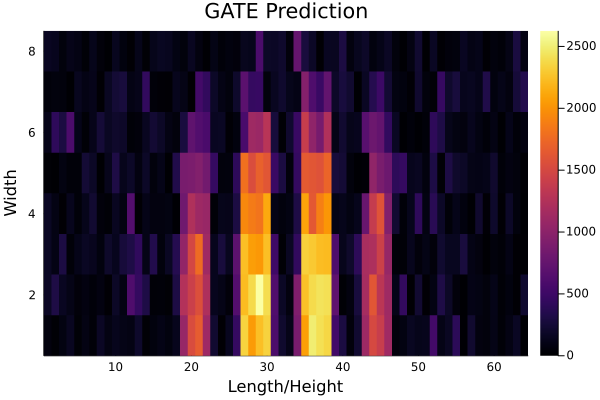

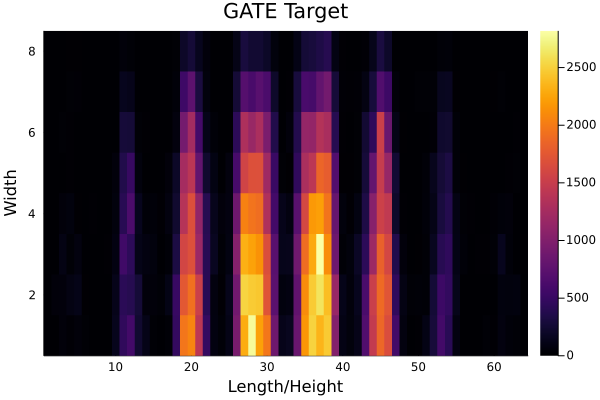

2576

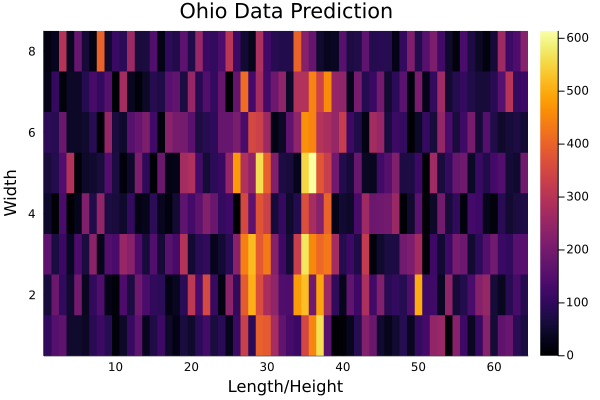

loss(trainingArray, targetArray) = 83684.19f0
loss(trainingArray, targetArray) = 77239.17f0
loss(trainingArray, targetArray) = 72345.62f0
loss(trainingArray, targetArray) = 69375.6f0
loss(trainingArray, targetArray) = 66642.96f0
loss(trainingArray, targetArray) = 64394.18f0
loss(trainingArray, targetArray) = 62659.25f0


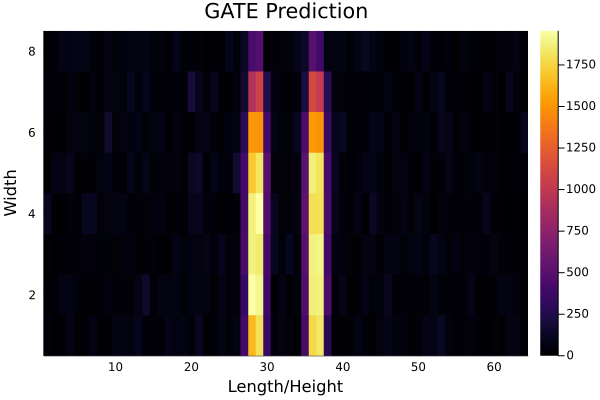

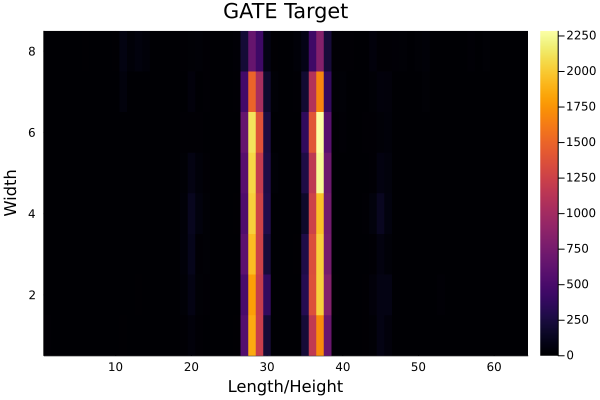

Training R2: 0.8934163626166208
Validation R2: 0.9098862130347558

	345

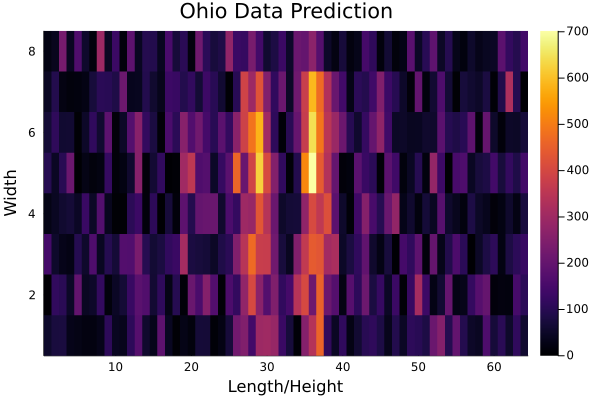

loss(trainingArray, targetArray) = 61765.598f0
loss(trainingArray, targetArray) = 60844.29f0
loss(trainingArray, targetArray) = 60052.96f0
loss(trainingArray, targetArray) = 59198.97f0
loss(trainingArray, targetArray) = 58545.37f0
loss(trainingArray, targetArray) = 58115.867f0
loss(trainingArray, targetArray) = 57738.918f0
Training R2: 0.9150899487173059
Validation R2: 0.925817788406389

	888

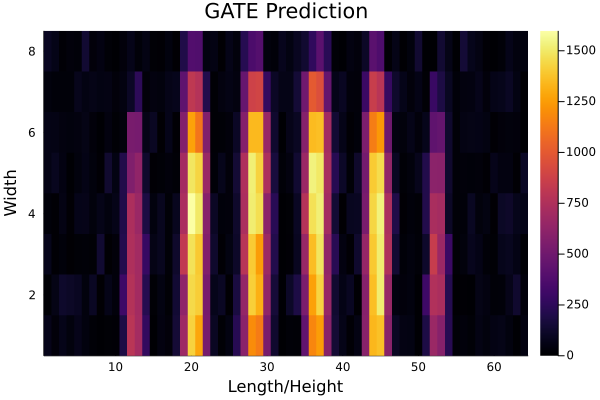

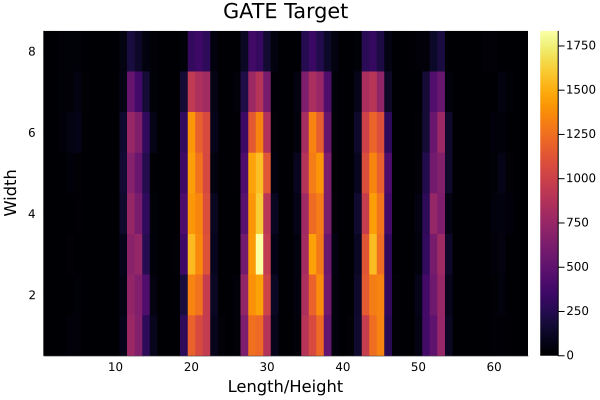

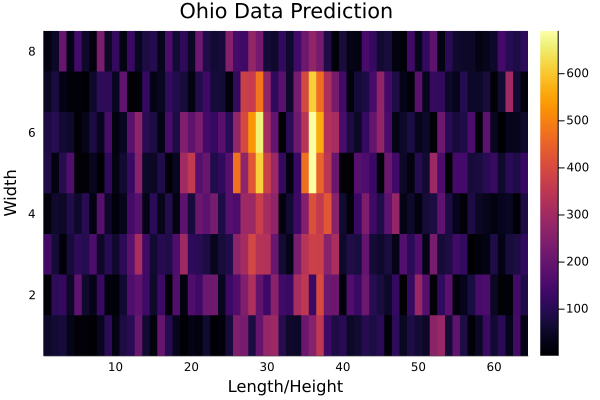

loss(trainingArray, targetArray) = 57456.605f0
loss(trainingArray, targetArray) = 57084.266f0
loss(trainingArray, targetArray) = 56825.46f0
loss(trainingArray, targetArray) = 56603.2f0
loss(trainingArray, targetArray) = 56378.973f0
loss(trainingArray, targetArray) = 56160.4f0
loss(trainingArray, targetArray) = 55974.273f0


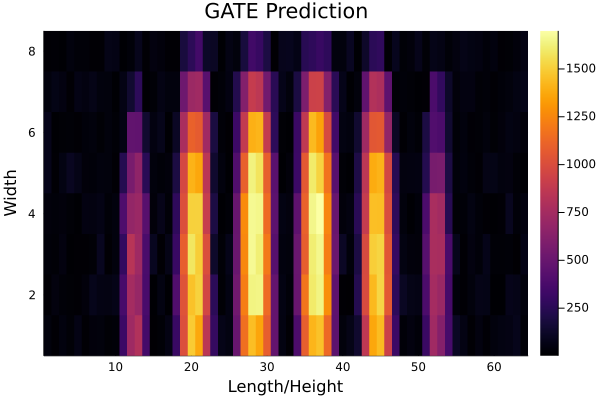

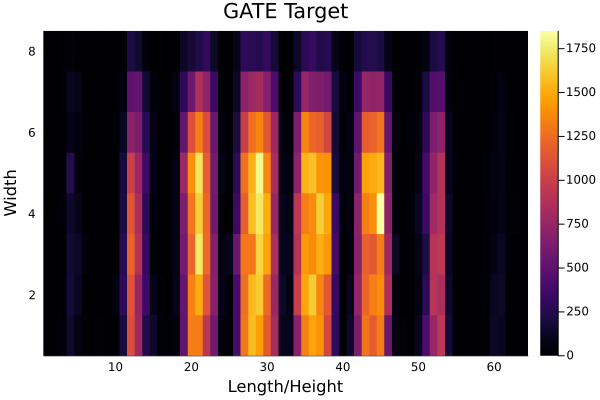

Training R2: 0.9279144075934023
Validation R2: 0.9355625302818512

	1193

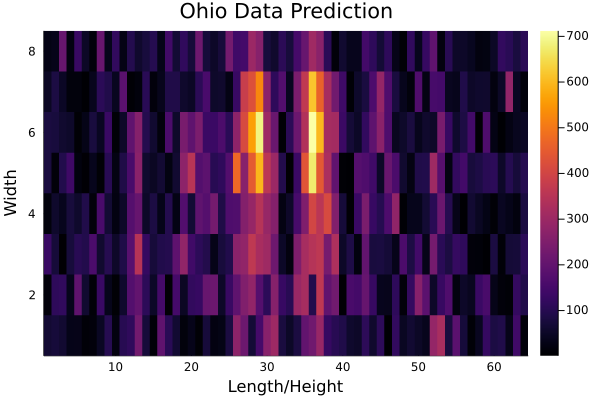

loss(trainingArray, targetArray) = 55860.42f0
loss(trainingArray, targetArray) = 55750.86f0
loss(trainingArray, targetArray) = 55584.32f0
loss(trainingArray, targetArray) = 55405.832f0
loss(trainingArray, targetArray) = 55224.42f0
loss(trainingArray, targetArray) = 55054.297f0
loss(trainingArray, targetArray) = 54888.797f0
Training R2: 0.9424008804713927
Validation R2: 0.9461484712244926

	2502

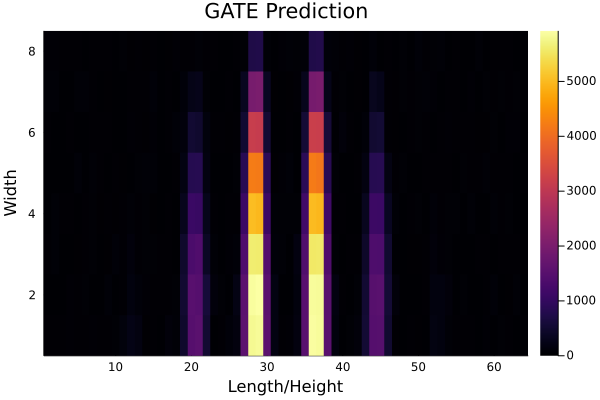

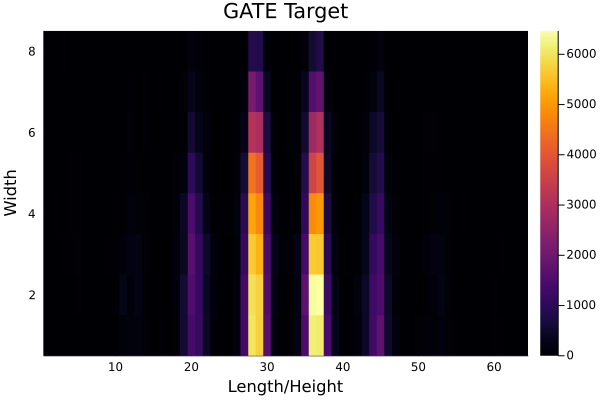

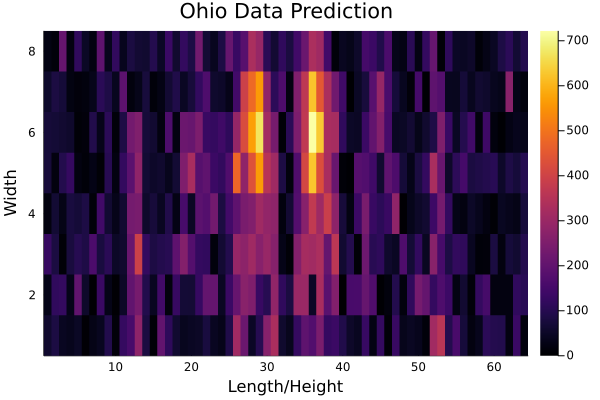

loss(trainingArray, targetArray) = 54743.12f0
loss(trainingArray, targetArray) = 54611.754f0
loss(trainingArray, targetArray) = 54499.87f0
loss(trainingArray, targetArray) = 54395.863f0
loss(trainingArray, targetArray) = 54301.03f0
loss(trainingArray, targetArray) = 54214.668f0
loss(trainingArray, targetArray) = 54136.74f0


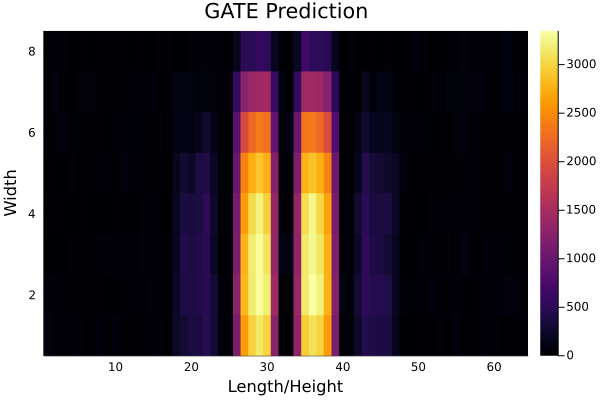

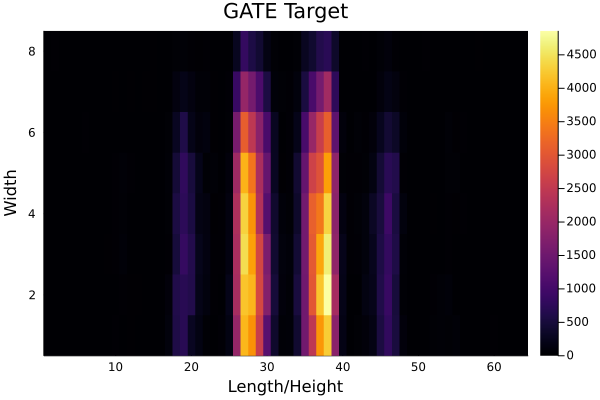

Training R2: 0.9442565995658915
Validation R2: 0.9483119867780473

	1260

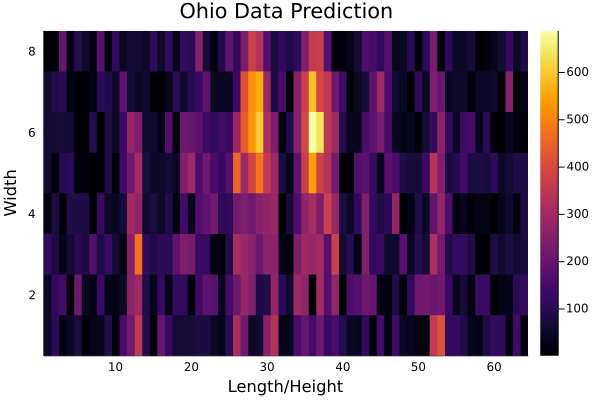

loss(trainingArray, targetArray) = 54090.19f0
loss(trainingArray, targetArray) = 54019.902f0
loss(trainingArray, targetArray) = 53959.207f0
loss(trainingArray, targetArray) = 53898.363f0
loss(trainingArray, targetArray) = 53844.71f0
loss(trainingArray, targetArray) = 53799.31f0
loss(trainingArray, targetArray) = 53747.703f0


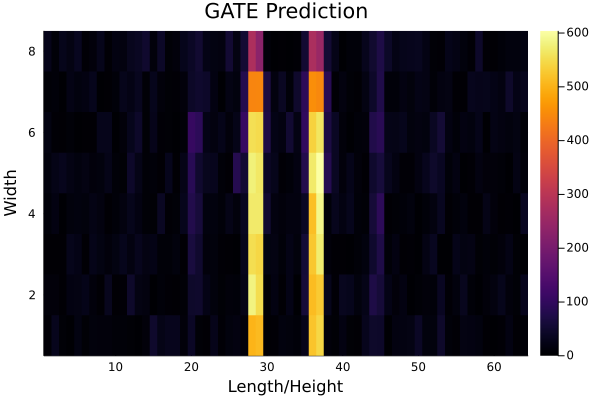

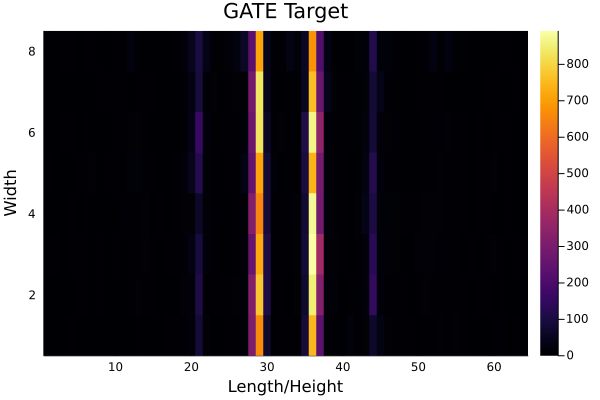

Training R2: 0.9485413656322295
Validation R2: 0.9507285419351692

	124

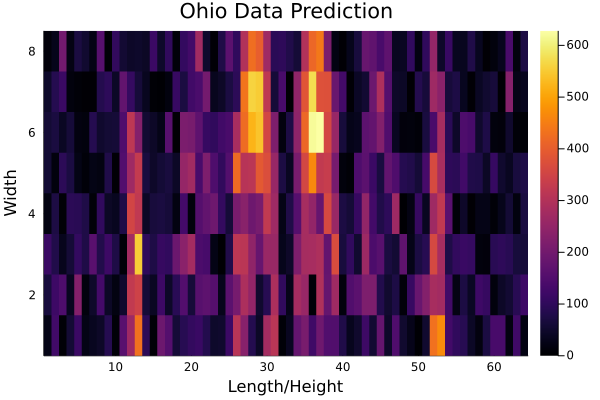

loss(trainingArray, targetArray) = 53719.074f0
loss(trainingArray, targetArray) = 53675.496f0
loss(trainingArray, targetArray) = 53633.152f0
loss(trainingArray, targetArray) = 53593.59f0
loss(trainingArray, targetArray) = 53556.17f0
loss(trainingArray, targetArray) = 53517.32f0
loss(trainingArray, targetArray) = 53481.617f0


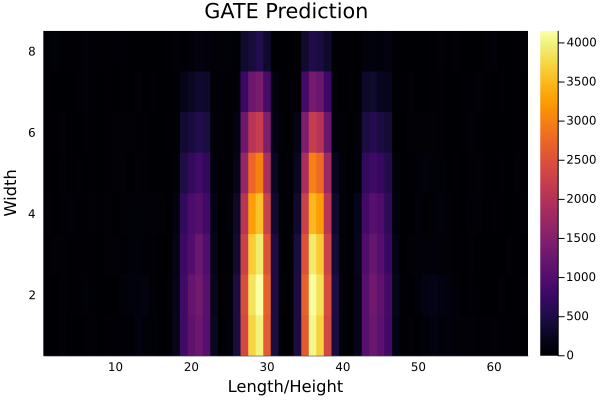

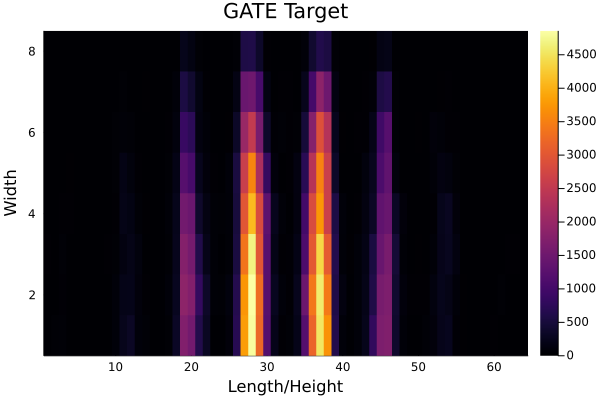

Training R2: 0.9609894520329091
Validation R2: 0.9552639395911079

	2183

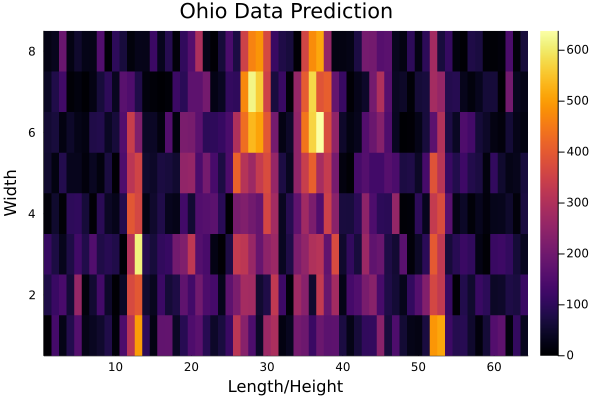

loss(trainingArray, targetArray) = 53458.996f0
loss(trainingArray, targetArray) = 53423.625f0
loss(trainingArray, targetArray) = 53393.605f0
loss(trainingArray, targetArray) = 53357.367f0
loss(trainingArray, targetArray) = 53325.695f0
loss(trainingArray, targetArray) = 53296.0f0
loss(trainingArray, targetArray) = 53273.906f0


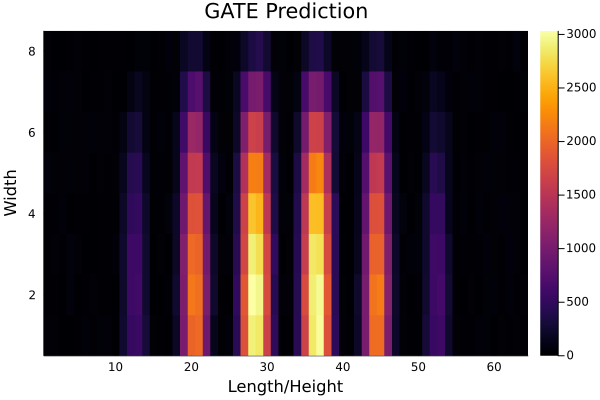

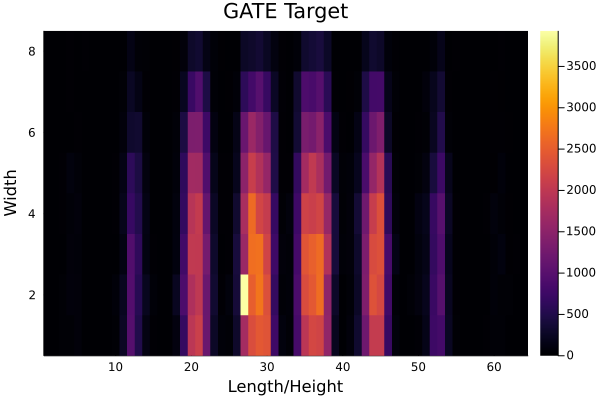

Training R2: 0.9655956841886941
Validation R2: 0.9605478409855039

	1730

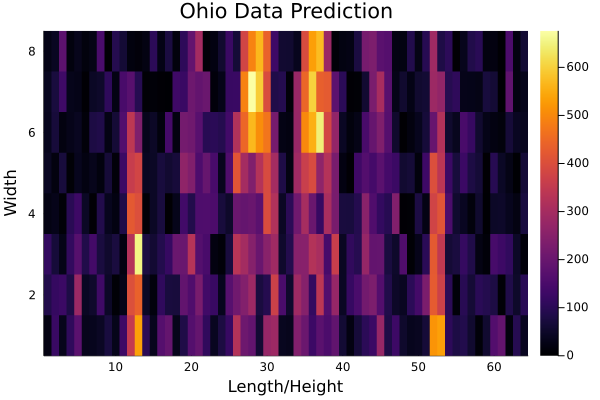

loss(trainingArray, targetArray) = 53243.145f0
loss(trainingArray, targetArray) = 53213.01f0
loss(trainingArray, targetArray) = 53193.957f0
loss(trainingArray, targetArray) = 53166.43f0
loss(trainingArray, targetArray) = 53142.723f0
loss(trainingArray, targetArray) = 53116.477f0
loss(trainingArray, targetArray) = 53086.35f0
loss(trainingArray, targetArray) = 53075.637f0


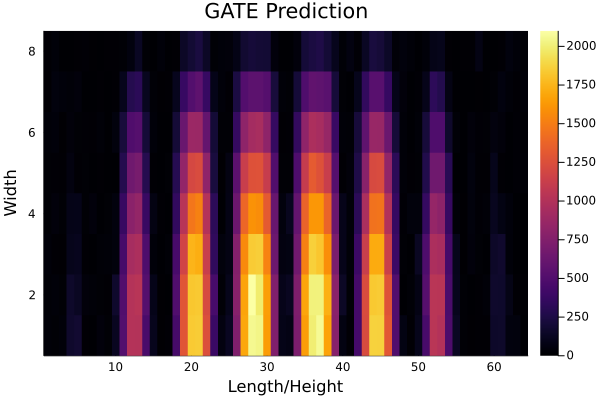

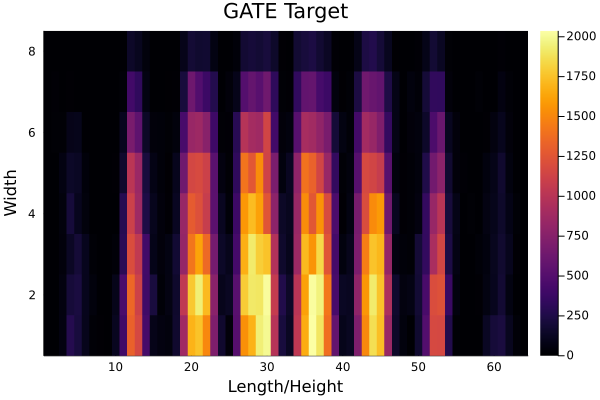

Training R2: 0.967955409230975
Validation R2: 0.964989250198118

	2393

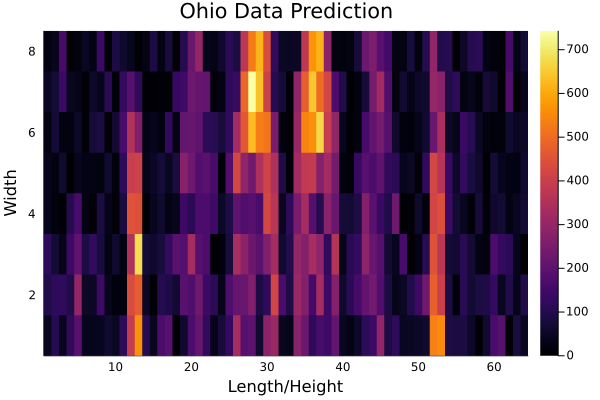

loss(trainingArray, targetArray) = 53061.676f0
loss(trainingArray, targetArray) = 53045.0f0
loss(trainingArray, targetArray) = 53017.84f0
loss(trainingArray, targetArray) = 52987.87f0
loss(trainingArray, targetArray) = 52966.418f0
loss(trainingArray, targetArray) = 52944.73f0
loss(trainingArray, targetArray) = 52924.625f0


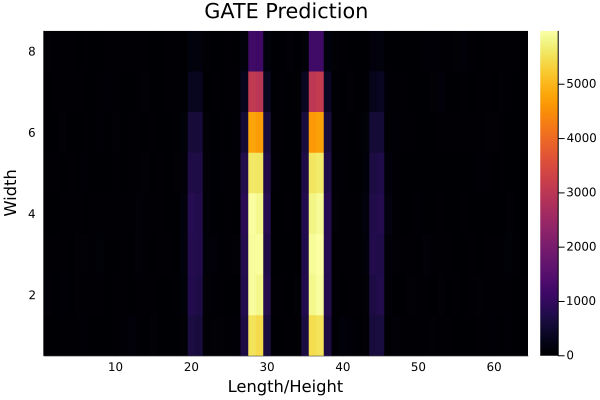

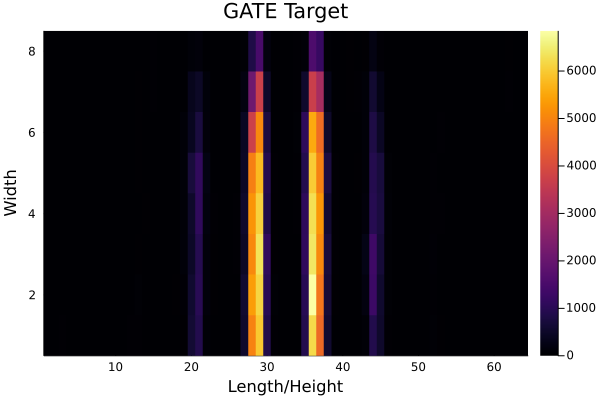

Training R2: 0.9697934646688681
Validation R2: 0.9687267835987123

	997

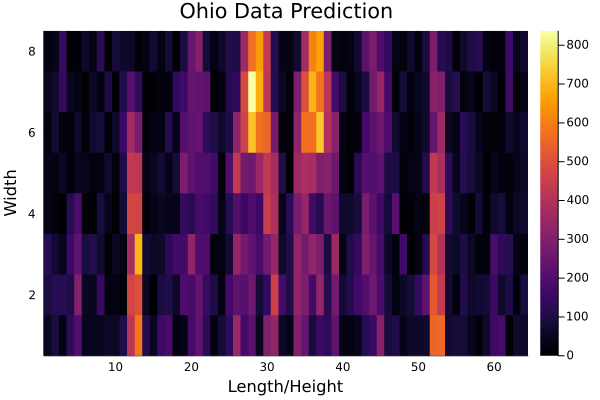

loss(trainingArray, targetArray) = 52904.312f0
loss(trainingArray, targetArray) = 52895.973f0
loss(trainingArray, targetArray) = 52866.992f0
loss(trainingArray, targetArray) = 52845.582f0
loss(trainingArray, targetArray) = 52825.523f0
loss(trainingArray, targetArray) = 52806.023f0
loss(trainingArray, targetArray) = 52781.6f0


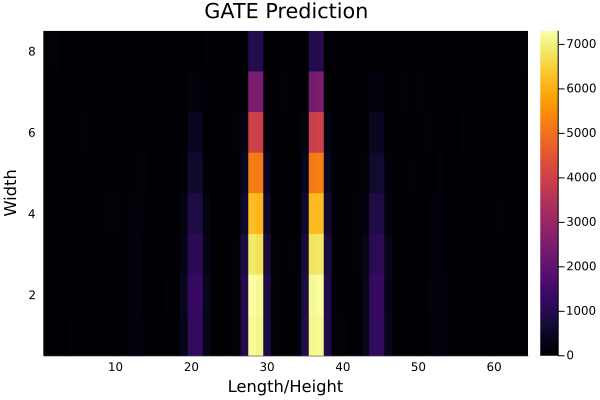

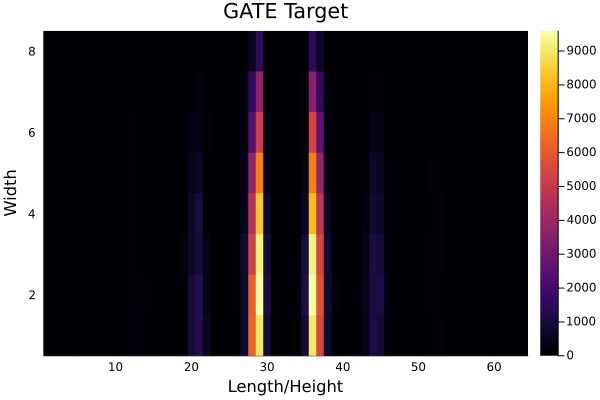

Training R2: 0.9718364675890495
Validation R2: 0.9710405248099142

	2162

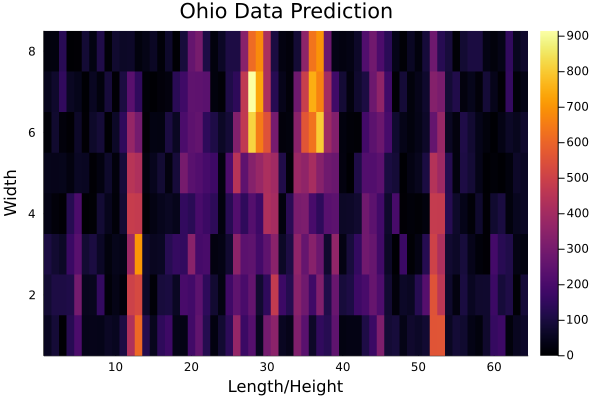

loss(trainingArray, targetArray) = 52757.82f0
loss(trainingArray, targetArray) = 52737.992f0
loss(trainingArray, targetArray) = 52717.426f0
loss(trainingArray, targetArray) = 52696.703f0
loss(trainingArray, targetArray) = 52673.97f0
loss(trainingArray, targetArray) = 52654.89f0
loss(trainingArray, targetArray) = 52637.254f0


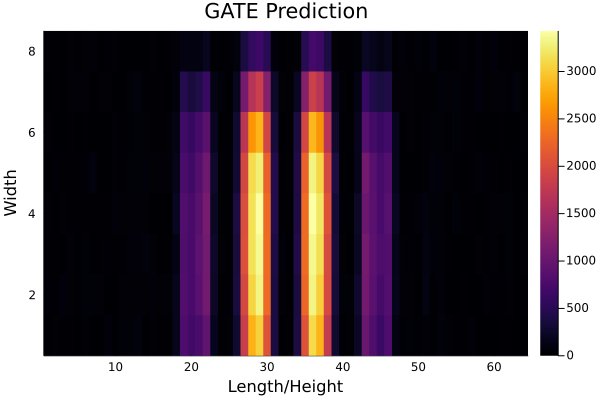

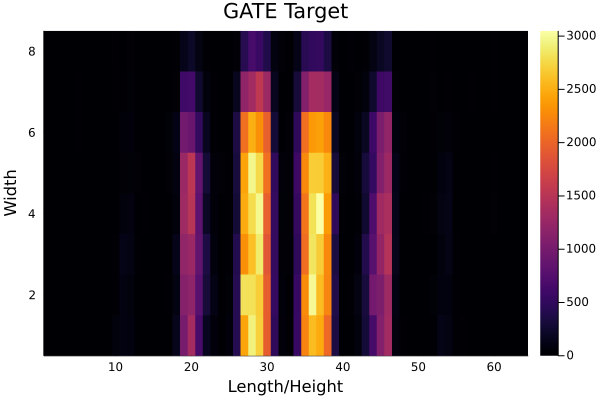

Training R2: 0.9765900478467882
Validation R2: 0.9742435935004061

	1044

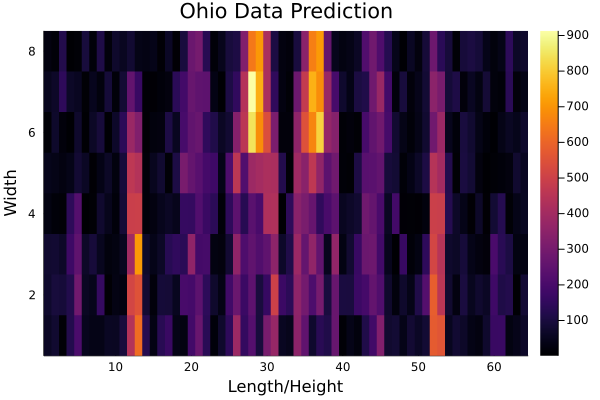

loss(trainingArray, targetArray) = 52622.008f0
loss(trainingArray, targetArray) = 52603.145f0
loss(trainingArray, targetArray) = 52585.402f0
loss(trainingArray, targetArray) = 52568.312f0
loss(trainingArray, targetArray) = 52545.93f0
loss(trainingArray, targetArray) = 52527.54f0
loss(trainingArray, targetArray) = 52509.766f0


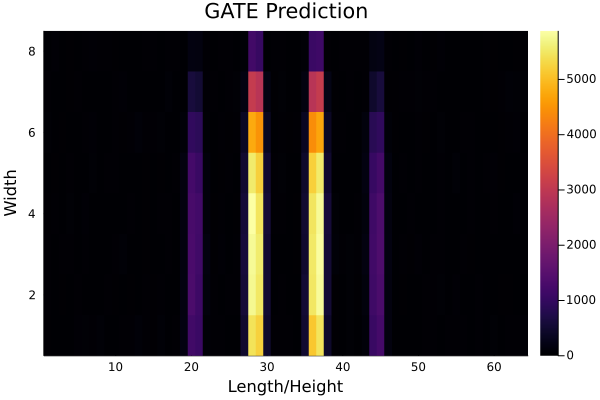

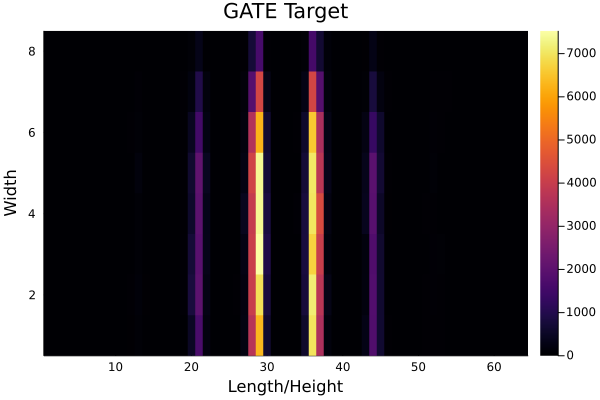

Training R2: 0.9820107974180562
Validation R2: 0.979862453758806

	1025

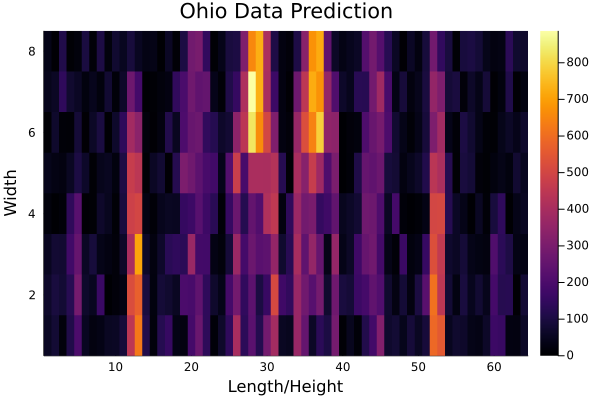

loss(trainingArray, targetArray) = 52499.75f0
loss(trainingArray, targetArray) = 52479.574f0
loss(trainingArray, targetArray) = 52460.47f0
loss(trainingArray, targetArray) = 52445.63f0
loss(trainingArray, targetArray) = 52428.57f0
loss(trainingArray, targetArray) = 52413.703f0
loss(trainingArray, targetArray) = 52399.51f0


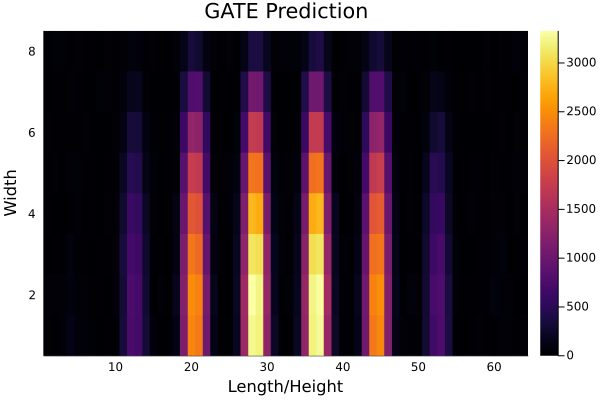

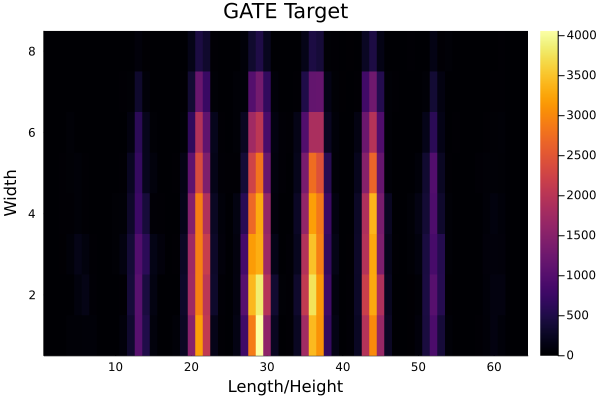

Training R2: 0.9864366538953316
Validation R2: 0.9855569189435397

	2051

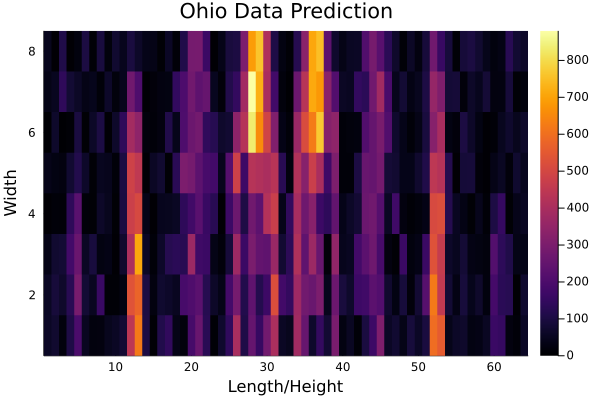

loss(trainingArray, targetArray) = 52387.53f0
loss(trainingArray, targetArray) = 52367.035f0
loss(trainingArray, targetArray) = 52357.83f0
loss(trainingArray, targetArray) = 52349.355f0
loss(trainingArray, targetArray) = 52330.777f0
loss(trainingArray, targetArray) = 52313.76f0
loss(trainingArray, targetArray) = 52297.94f0
loss(trainingArray, targetArray) = 52290.81f0


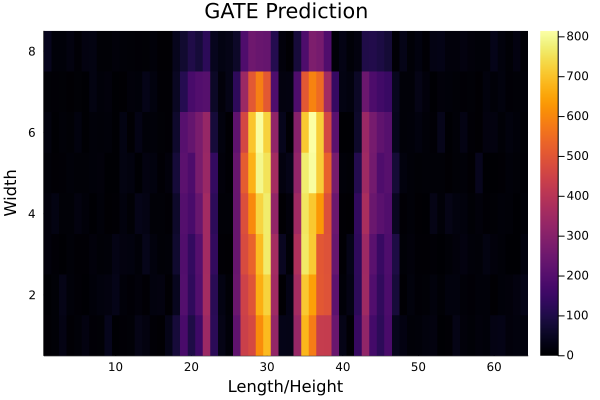

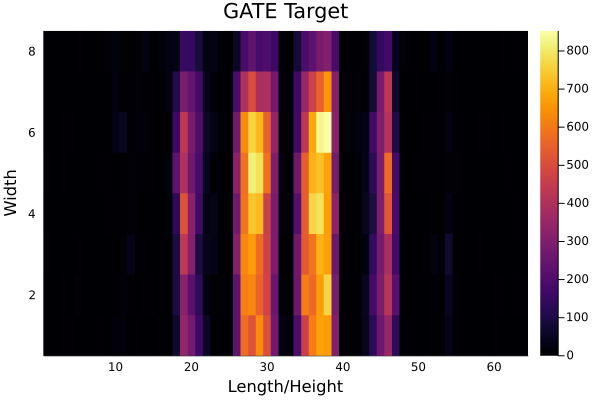

Training R2: 0.9889167798330883
Validation R2: 0.988715107662205

	450

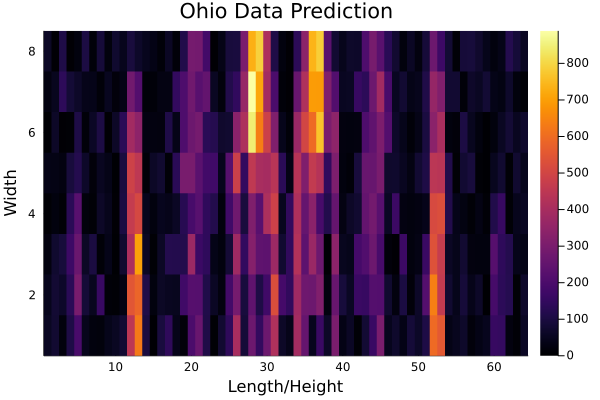

loss(trainingArray, targetArray) = 52287.59f0
loss(trainingArray, targetArray) = 52271.855f0
loss(trainingArray, targetArray) = 52258.07f0
loss(trainingArray, targetArray) = 52245.113f0
loss(trainingArray, targetArray) = 52234.066f0
loss(trainingArray, targetArray) = 52221.58f0
loss(trainingArray, targetArray) = 52205.254f0


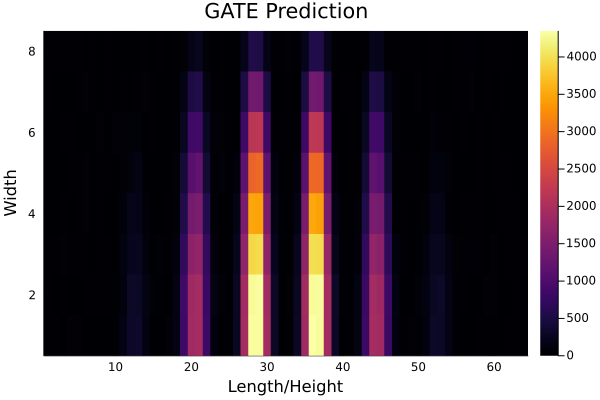

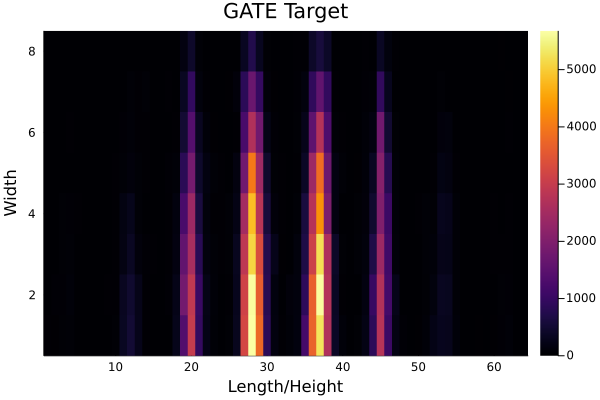

Training R2: 0.9895081324792613
Validation R2: 0.9903720555184216

	2479

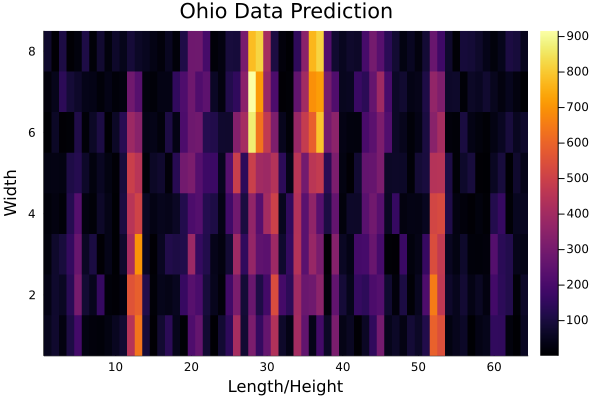

loss(trainingArray, targetArray) = 52202.24f0
loss(trainingArray, targetArray) = 52189.58f0
loss(trainingArray, targetArray) = 52184.72f0
loss(trainingArray, targetArray) = 52170.793f0
loss(trainingArray, targetArray) = 52155.137f0
loss(trainingArray, targetArray) = 52143.41f0
loss(trainingArray, targetArray) = 52129.586f0
Training R2: 0.9897551442034666
Validation R2: 0.990754644506603

	2961

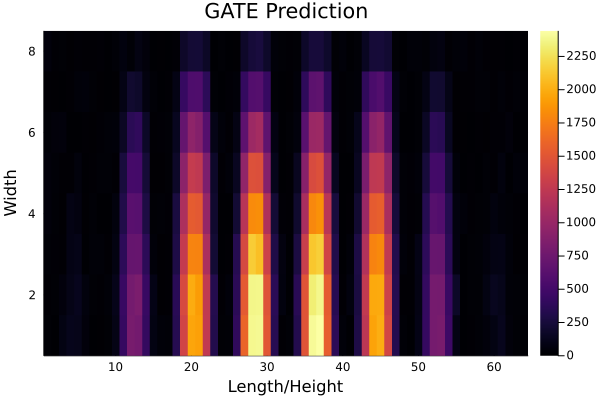

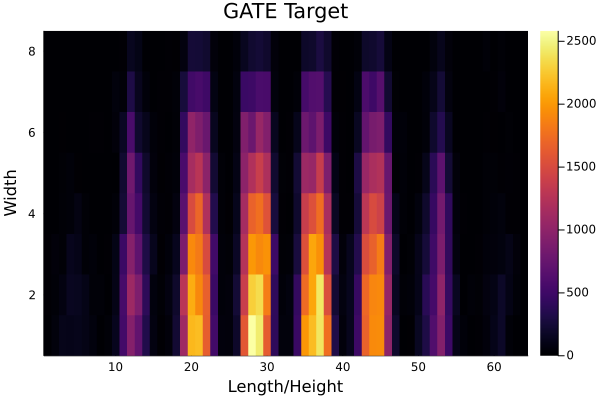

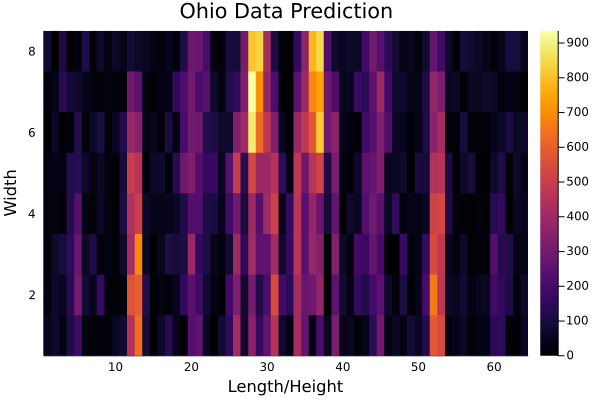

loss(trainingArray, targetArray) = 52129.98f0
loss(trainingArray, targetArray) = 52112.637f0
loss(trainingArray, targetArray) = 52095.984f0
loss(trainingArray, targetArray) = 52087.56f0
loss(trainingArray, targetArray) = 52084.965f0
loss(trainingArray, targetArray) = 52083.92f0
loss(trainingArray, targetArray) = 52064.008f0
loss(trainingArray, targetArray) = 52050.47f0
Training R2: 0.9898305602886045
Validation R2: 0.9912127435323312

	1736

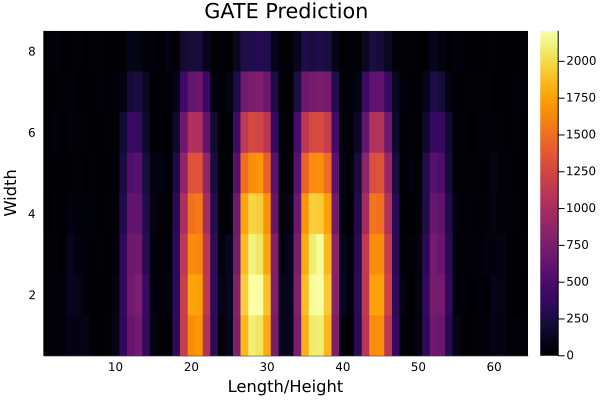

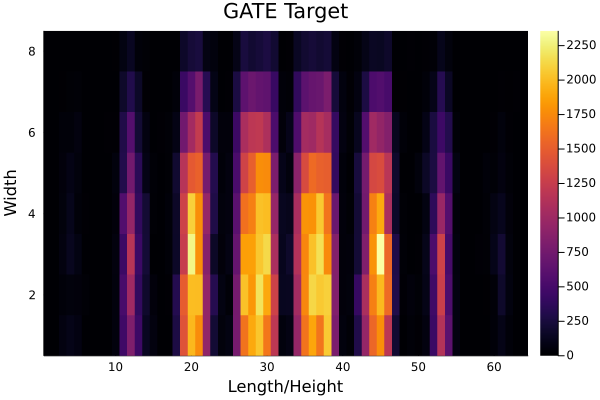

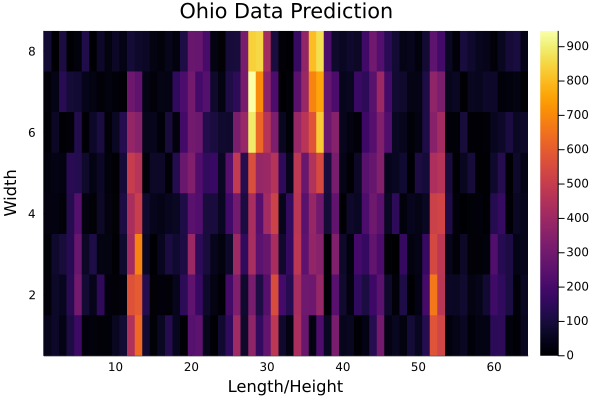

loss(trainingArray, targetArray) = 52046.688f0
loss(trainingArray, targetArray) = 52038.457f0
loss(trainingArray, targetArray) = 52030.31f0
loss(trainingArray, targetArray) = 52022.508f0
loss(trainingArray, targetArray) = 52015.52f0
loss(trainingArray, targetArray) = 52001.24f0
loss(trainingArray, targetArray) = 51989.438f0
Training R2: 0.9897126402283698
Validation R2: 0.9916481611861518

	240

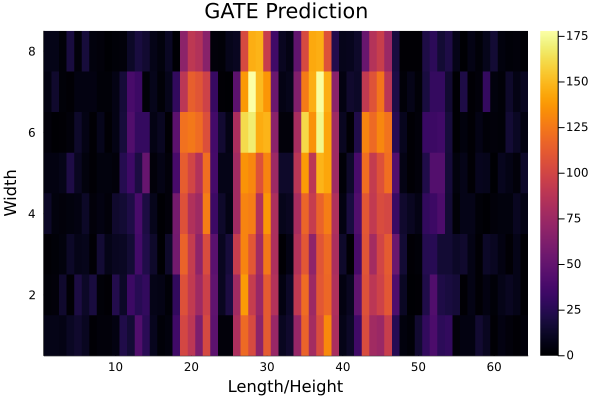

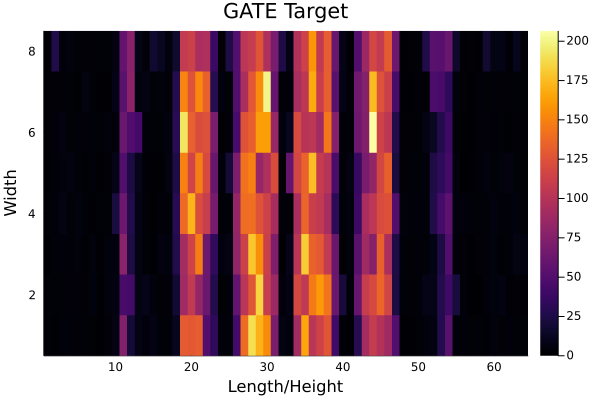

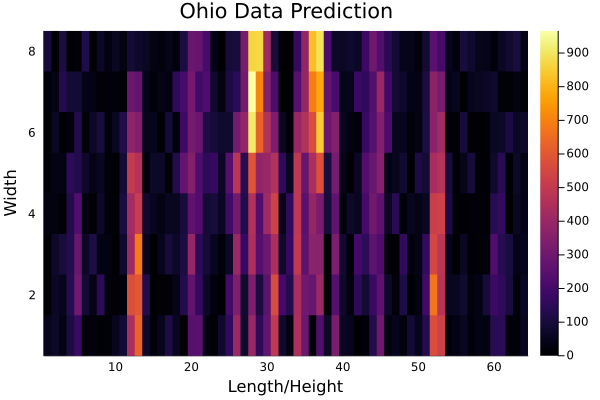

In [30]:
while i <= 20
    CVR2 = CurrentVR2
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 5))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
    i = i+1
end

In [31]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/OptimizedRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
            
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(i+2,3)][1:13]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(m(validationArray)[:,i], (8*8,8)), " ")
    end


    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [32]:
writeOutput(m)